0.92


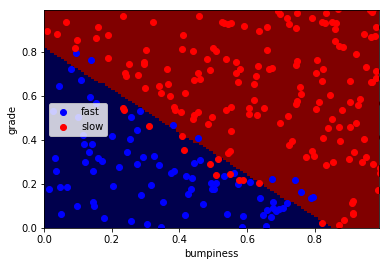

In [6]:
import sys
sys.path.append("Eva/Users/evamush/Documents/ud120-projects/tools/")
sys.path.append('Eva/Users/evamush/Documents/ud120-projects/choose_your_own')
sys.path.append('Eva/Users/evamush/Documents/ud120-projects/svm')

#!/usr/bin/python
                         
import sys
import matplotlib.pyplot as plt
import copy
import numpy as np
import pylab as pl

def prettyPicture(clf, X_test, y_test):
    x_min = 0.0; x_max = 1.0
    y_min = 0.0; y_max = 1.0
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.pcolormesh(xx, yy, Z, cmap=pl.cm.seismic)

    # Plot also the test points
    grade_sig = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==0]
    bumpy_sig = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==0]
    grade_bkg = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==1]
    bumpy_bkg = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==1]

    plt.scatter(grade_sig, bumpy_sig, color = "b", label="fast")
    plt.scatter(grade_bkg, bumpy_bkg, color = "r", label="slow")
    plt.legend()
    plt.xlabel("bumpiness")
    plt.ylabel("grade")

    plt.savefig("test.png")
    
import base64
import json
import subprocess

def output_image(name, format, bytes):
    image_start = "BEGIN_IMAGE_f9825uweof8jw9fj4r8"
    image_end = "END_IMAGE_0238jfw08fjsiufhw8frs"
    data = {}
    data['name'] = name
    data['format'] = format
    data['bytes'] = base64.encodestring(bytes)
    print image_start+json.dumps(data)+image_end

#!/usr/bin/python
import random


def makeTerrainData(n_points=1000):
###############################################################################
### make the toy dataset
    random.seed(42)
    grade = [random.random() for ii in range(0,n_points)]
    bumpy = [random.random() for ii in range(0,n_points)]
    error = [random.random() for ii in range(0,n_points)]
    y = [round(grade[ii]*bumpy[ii]+0.3+0.1*error[ii]) for ii in range(0,n_points)]
    for ii in range(0, len(y)):
        if grade[ii]>0.8 or bumpy[ii]>0.8:
            y[ii] = 1.0

### split into train/test sets
    X = [[gg, ss] for gg, ss in zip(grade, bumpy)]
    split = int(0.75*n_points)
    X_train = X[0:split]
    X_test  = X[split:]
    y_train = y[0:split]
    y_test  = y[split:]

    grade_sig = [X_train[ii][0] for ii in range(0, len(X_train)) if y_train[ii]==0]
    bumpy_sig = [X_train[ii][1] for ii in range(0, len(X_train)) if y_train[ii]==0]
    grade_bkg = [X_train[ii][0] for ii in range(0, len(X_train)) if y_train[ii]==1]
    bumpy_bkg = [X_train[ii][1] for ii in range(0, len(X_train)) if y_train[ii]==1]

    training_data = {"fast":{"grade":grade_sig, "bumpiness":bumpy_sig}
            , "slow":{"grade":grade_bkg, "bumpiness":bumpy_bkg}}


    grade_sig = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==0]
    bumpy_sig = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==0]
    grade_bkg = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==1]
    bumpy_bkg = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==1]

    test_data = {"fast":{"grade":grade_sig, "bumpiness":bumpy_sig}
            , "slow":{"grade":grade_bkg, "bumpiness":bumpy_bkg}}

    return X_train, y_train, X_test, y_test
    

from sklearn.metrics import accuracy_score
features_train, labels_train, features_test, labels_test = makeTerrainData()


########################## SVM #################################
from sklearn.svm import SVC

def submitAccuracy():
    return accuracy_score(pred, labels_test)

clf = SVC(kernel="linear",C=1)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

print accuracy_score(pred, labels_test)

# %matplotlib inline
prettyPicture(clf, features_test, labels_test)
plt.show() #

0.948


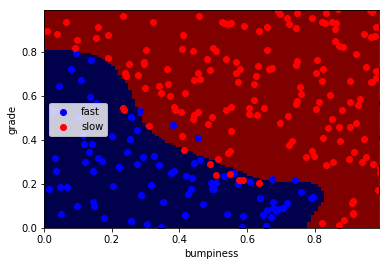

In [7]:
clf = SVC(kernel="rbf",C=100000,gamma=5)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

print accuracy_score(pred, labels_test)

# %matplotlib inline
prettyPicture(clf, features_test, labels_test)
plt.show() #

0.944


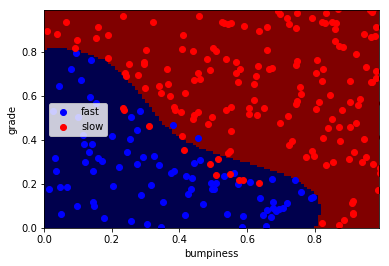

In [8]:
### Use grid search to find the best parameters

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svr = SVC(class_weight='balanced')
params_grid = {
    'C': [1.0, 10.0, 100.0, 1000.0, 10000.0],
    'kernel': ['rbf', 'linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['auto']
}

clf = GridSearchCV(svr, params_grid)
clf.fit(features_train, labels_train)

pred = clf.predict(features_test)

print accuracy_score(pred, labels_test)

# %matplotlib inline
prettyPicture(clf, features_test, labels_test)
plt.show() #

In [43]:
#!/usr/bin/python
import sys
import os
import pickle
import cPickle
import numpy

from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif



def preprocess(words_file = "../tools/word_data.pkl", authors_file="../tools/email_authors.pkl"):
    """ 
        this function takes a pre-made list of email texts (by default word_data.pkl)
        and the corresponding authors (by default email_authors.pkl) and performs
        a number of preprocessing steps:
            -- splits into training/testing sets (10% testing)
            -- vectorizes into tfidf matrix
            -- selects/keeps most helpful features

        after this, the feaures and labels are put into numpy arrays, which play nice with sklearn functions

        4 objects are returned:
            -- training/testing features
            -- training/testing labels

    """

    ### the words (features) and authors (labels), already largely preprocessed
    ### this preprocessing will be repeated in the text learning mini-project
   

    words_file_handler = open(words_file, "r")
    word_data = cPickle.load(words_file_handler)
    words_file_handler.close()
    
    authors_file_handler = open(authors_file, "r")
    authors = pickle.load(authors_file_handler)
    authors_file_handler.close()

    ### test_size is the percentage of events assigned to the test set
    ### (remainder go into training)
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(word_data, authors, test_size=0.1, random_state=42)



    ### text vectorization--go from strings to lists of numbers
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    features_train_transformed = vectorizer.fit_transform(features_train)
    features_test_transformed  = vectorizer.transform(features_test)



    ### feature selection, because text is super high dimensional and 
    ### can be really computationally chewy as a result
    selector = SelectPercentile(f_classif, percentile=10)
    selector.fit(features_train_transformed, labels_train)
    features_train_transformed = selector.transform(features_train_transformed).toarray()
    features_test_transformed  = selector.transform(features_test_transformed).toarray()

    ### info on the data
    print "no. of Chris training emails:", sum(labels_train)
    print "no. of Sara training emails:", len(labels_train)-sum(labels_train)
    
    return features_train_transformed, features_test_transformed, labels_train, labels_test


In [44]:
from time import time

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


### features_train and features_test are the features for the training
### and testing datasets, respectively
### labels_train and labels_test are the corresponding item labels
features_train, features_test, labels_train, labels_test = preprocess()


def my_svm(features_train, features_test, labels_train, labels_test, kernel='linear', C=1.0):

    clf = SVC(kernel='linear', C=1)
    
    # train
    t0 = time()
    clf.fit(features_train, labels_train)
    print "\ntraining time:", round(time()-t0, 3), "s"
    
    # predict
    t0 = time()
    pred = clf.predict(features_test)
    print "predicting time:", round(time()-t0, 3), "s"
    
    accuracy = accuracy_score(pred, labels_test)

    print '\naccuracy = {0}'.format(accuracy)
    return pred

pred = my_svm(features_train, features_test, labels_train, labels_test)

IOError: [Errno 2] No such file or directory: '../tools/word_data.pkl'